In [1]:
import os
import tifffile
import numpy as np
import phathom.phenotype.mesh as mesh

In [2]:
working_dir = '/media/jswaney/SSD EVO 860/organoid_phenotyping/20181210_eF9_A34_2'

# Load detected nuclei, cell-type labels, and VZ segmentation

In [3]:
centers_path = 'centers.npy'
sox2_labels_path = 'sox2_labels.npy'
tbr1_labels_path = 'tbr1_labels.npy'

centers = np.load(os.path.join(working_dir, centers_path))
sox2_labels = np.load(os.path.join(working_dir, sox2_labels_path))
tbr1_labels = np.load(os.path.join(working_dir, tbr1_labels_path))

centers.shape

(1556799, 3)

In [4]:
voxel_size = (2.052, 1.082, 1.082)

centers_um = mesh.voxels_to_micron(centers, voxel_size)

In [5]:
input_segmentation = 'sox2_4x_downsampled_vzseg.tif'
sigma = 2

vz_seg = tifffile.imread(os.path.join(working_dir, input_segmentation))
vz_seg_smooth = mesh.smooth_segmentation(vz_seg, sigma=sigma)

vz_seg_smooth.shape, vz_seg_smooth.max()

((646, 619, 638), 10.0)

In [6]:
output_segmentation = 'sox2_4x_downsampled_vzseg_smooth2.tif'

tifffile.imsave(os.path.join(working_dir, output_segmentation), vz_seg_smooth, compress=1)

# Compute VZ mesh to get surface normals

In [7]:
level = 1  # Isosurface intensity
spacing = (2.052, 1.082 * 3.7, 1.082 * 3.7)
step_size = 1  # Larger gives coarse mesh

verts, faces, normals, values = mesh.marching_cubes(vz_seg_smooth, level=level, spacing=spacing, step_size=step_size)

In [8]:
# Save the mesh
np.save(os.path.join(working_dir, 'verts.npy'), verts)
np.save(os.path.join(working_dir, 'faces.npy'), faces)
np.save(os.path.join(working_dir, 'normals.npy'), normals)
np.save(os.path.join(working_dir, 'values.npy'), values)

In [9]:
# Load precomputed mesh
verts = np.load(os.path.join(working_dir, 'verts.npy'))
faces = np.load(os.path.join(working_dir, 'faces.npy'))
normals = np.load(os.path.join(working_dir, 'normals.npy'))
values = np.load(os.path.join(working_dir, 'values.npy'))

# Check the VZ mesh and nuclei in a 3D render

In [6]:
nb_nuclei = 100000
scale_factor = 8

mesh.plot_mesh(verts, faces)
mesh.plot_nuclei(centers_um, nb_nuclei, sox2_labels, tbr1_labels, scale_factor)
mesh.show3d()

# Compute VZ profiles for sampled normals

In [10]:
nb_normals = 2000

verts2, faces2, normals2, values2 = mesh.randomly_sample(nb_normals, verts, faces, normals, values)

In [11]:
length = 200  # micron
radius = 25  # micron
bins = 5

counts = mesh.compute_profiles(verts2, normals2, length, bins, radius, centers_um, sox2_labels, tbr1_labels)

100%|██████████| 2000/2000 [03:37<00:00,  9.18it/s]


In [13]:
# Save results
np.save(os.path.join(working_dir, 'counts.npy'), counts)

In [15]:
np.save(os.path.join(working_dir, 'verts_sampled.npy'), verts2)
np.save(os.path.join(working_dir, 'faces_sampled.npy'), faces2)
np.save(os.path.join(working_dir, 'normals_sampled.npy'), normals2)
np.save(os.path.join(working_dir, 'values_sampled.npy'), values2)

In [7]:
# Load saved results
counts = np.load('counts.npy')

In [ ]:
verts2 = np.load(os.path.join(working_dir, 'verts_sampled.npy'))
faces2 = np.load(os.path.join(working_dir, 'faces_sampled.npy'))
normals2 = np.load(os.path.join(working_dir, 'normals_sampled.npy'))
values2 = np.load(os.path.join(working_dir, 'values_sampled.npy'))

# Perform hierarchical clustering of VZ normals

In [16]:
# counts to features
features = mesh.counts_to_features(counts.astype(np.float))

In [17]:
n_clusters = 5
linkage = 'ward'  # ward, complete, average, single

labels = mesh.hierarchical_clustering(features, n_clusters, linkage)

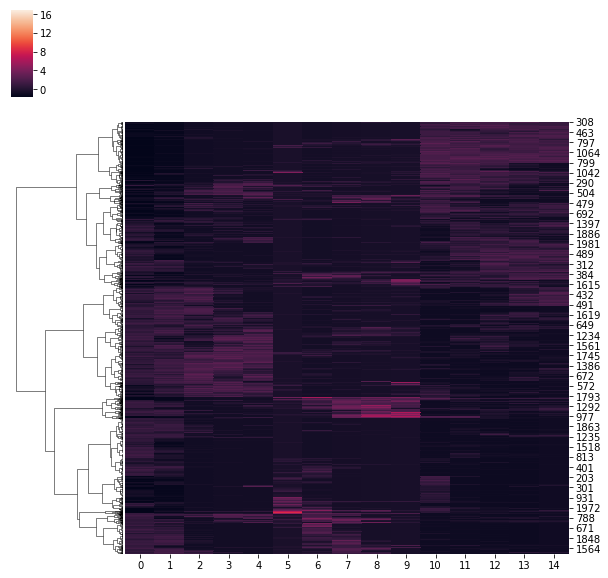

In [18]:
mesh.plot_clustermap(features, linkage)

In [19]:
# separate verts, normals, etc by cluster labels
cluster_idx, (cluster_verts, cluster_normals) = mesh.separate_by_labels(labels, verts2, normals2)

for i, idx in enumerate(cluster_idx):
    print(f"Cluster {i} has {100 * len(idx) / nb_normals} % of all sampled normals")

Cluster 0 has 31.25 % of all sampled normals
Cluster 1 has 23.85 % of all sampled normals
Cluster 2 has 25.5 % of all sampled normals
Cluster 3 has 4.9 % of all sampled normals
Cluster 4 has 14.5 % of all sampled normals


In [20]:
colors = mesh.colormap_to_colors(n_clusters)

In [21]:
opacity = 1.0

mesh.plot_mesh(verts, faces)
mesh.plot_normals(cluster_verts, cluster_normals, colors, opacity)
mesh.show3d()

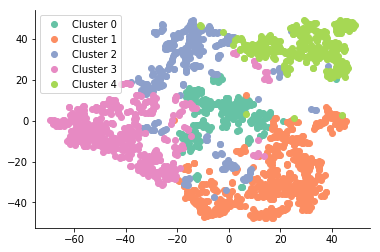

In [44]:
mesh.plot_tsne(features, labels, colors)

/home/jswaney/anaconda3/envs/phathom/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


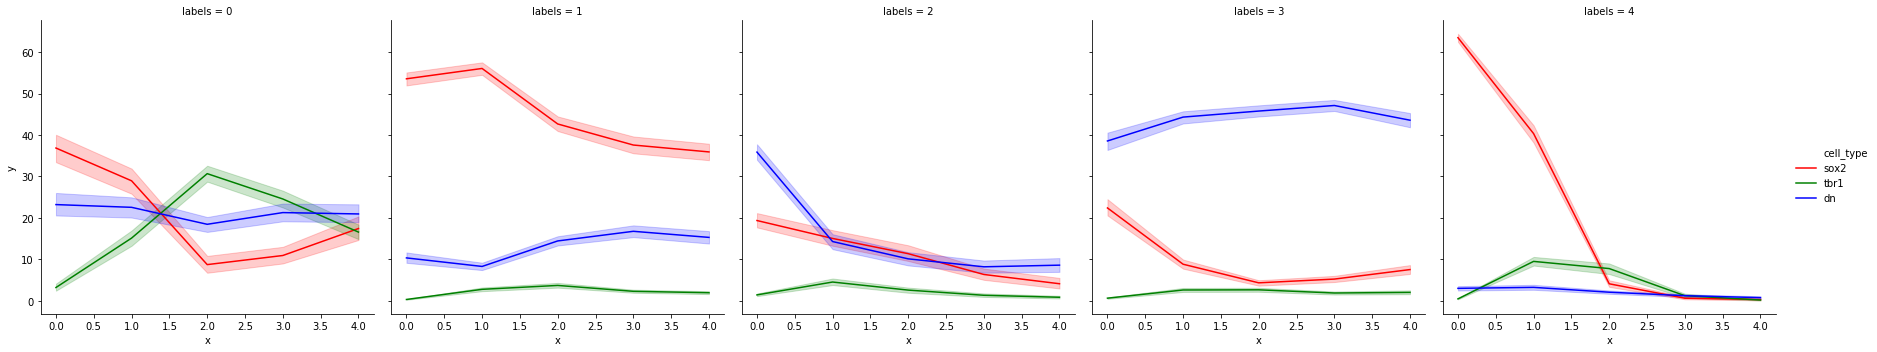

In [45]:
mesh.plot_cluster_profiles(counts, labels)